In [2]:
import numpy as np


In [3]:
def gsog(X):
    """
    Gram-Schmidt orthogonalization

    Parameters:
    - X (ndarray): Input matrix of size (d, n)

    Returns:
    - Q (ndarray): Orthogonalized matrix of size (d, m)
    - R (ndarray): Upper triangular matrix of size (m, n)
    """

    d, n = X.shape
    m = min(d, n)

    R = np.eye(m, n)
    Q = np.zeros((d, m))
    D = np.zeros(m)

    for i in range(m):
        R[0:i, i] = np.dot(np.multiply(Q[:, 0:i], 1 / D[0:i]).T, X[:, i])
        Q[:, i] = X[:, i] - np.dot(Q[:, 0:i], R[0:i, i])
        D[i] = np.dot(Q[:, i], Q[:, i])

    R[:, m:n] = np.dot(np.multiply(Q, 1 / D).T, X[:, m:n])

    return Q, R

In [85]:
def build_TDR_subspace(before_learning_X, before_learning_N, after_learning_X=None , after_learning_N=None, TDR_options=1):
    """
    Perform TDR analyses as in Sun, O'Shea et al, 2021.

    Parameters:
    - before_learning_X (ndarray): Behavioral variables before learning (C by M matrix)
    - after_learning_X (ndarray): Behavioral variables after learning (C by M matrix)
    - before_learning_N (ndarray): Condition-averaged, centered neural activity before learning (C by N matrix)
    - after_learning_N (ndarray): Condition-averaged, centered neural activity after learning (C by N matrix)
    - TDR_options (int): Indicator of whether to use before-learning data (1), after-learning data (2), or both (3)

    Returns:
    - betaNeural2Behav (ndarray): Matrix of un-orthogonalized coefficients projecting neural activity to TDR axes
    - betaNeural2BehavOrth (ndarray): Matrix of orthogonalized coefficients projecting neural activity to TDR axes
    - projectedStates (ndarray): Matrix of neural state coordinates on orthogonalized TDR axes
    """

    # Now build the TDR subspace
    if TDR_options == 1:
        X = before_learning_X
        N = before_learning_N
    elif TDR_options == 2:
        X = after_learning_X
        N = after_learning_N
    elif TDR_options == 3:
        X = np.vstack((before_learning_X, after_learning_X))
        N = np.vstack((before_learning_N, after_learning_N))
    else:
        raise ValueError("Invalid value for TDR_options. Choose 1, 2, or 3.")

    # Get ready the design matrix (behavioral variables + intercept).
    behav = np.hstack((X, np.ones((X.shape[0], 1))))

    # Regress neural data against the design matrix and compute the regression coefficients.
    betaBehav2Neural = np.linalg.lstsq(behav, N, rcond=None)[0]

    # Compute the TDR axes.
    betaNeural2Behav = np.linalg.pinv(betaBehav2Neural)
    betaNeural2Behav = betaNeural2Behav[:, :X.shape[1]]

    # Orthogonalize the TDR axes before projection.
    betaNeural2BehavOrth = gsog(betaNeural2Behav)

    # Project before-learning and after-learning neural activity onto the TDR axes
    projectedStates = np.vstack((before_learning_N, after_learning_N)) @ betaNeural2BehavOrth[0]

    return betaNeural2Behav, betaNeural2BehavOrth, projectedStates


In [6]:
a = np.random.randn(9, 6)
Q, R = gsog(a)
# replace and see
#Q1, R1 = np.linalg.qr(a)

In [92]:
# get data
import os
import sys 
sys.path.append(os.path.abspath('..'))

from utils import create_directory
from model import test
from pathlib import Path


data_dir = create_directory(directory_name='pert') # loss0_if

In [107]:
model_num = 15
# pert - input fix [0,11,13]
# loss0_if - [2,3,7,13] 
model_name = "model{:02d}".format(model_num)
data = []
phases = ['NF1','FF1']
ff = [0,8]

for i,p in enumerate(phases):
    weight_file = list(Path(data_dir).glob(f'{model_name}_phase={p}_*_weights'))[0]
    cfg_file = list(Path(data_dir).glob(f'{model_name}_phase={p}_*_cfg.json'))[0]
    data.append(test(cfg_file,weight_file,ff_coefficient=ff[i]))

In [108]:
from sklearn.decomposition import PCA


# get_data
Data_prep =  {'X':[],'X_ldim':[],'Y':[]}


for i in range(len(phases)):
    
    # behavior
    vel = np.array(data[i]['vel'])
    vel_norm = np.linalg.norm(vel,axis=-1)
    max_vel_idx = np.argmax(vel_norm,axis=1)

    muscle_force = np.array(data[i]['all_force'])
    n_cond = muscle_force.shape[0]

    muscle_force_at_peak_vel = muscle_force[np.arange(n_cond), max_vel_idx, :]
    Data_prep['X'].append(muscle_force_at_peak_vel)

    # low d behavior
    # TODO: need to for the pca over all phases...
    pca = PCA(n_components=6)
    X_pca = pca.fit_transform(muscle_force_at_peak_vel)
    X_pca = X_pca[:, :2]
    Data_prep['X_ldim'].append(X_pca)
    
    # neural
    go_cue_idx = 10
    fr = np.array(data[i]['all_hidden'])
    fr_at_go_cue = fr[:, go_cue_idx, :]
    Data_prep['Y'].append(fr_at_go_cue)

In [109]:
# run basic tdr
betaNeural2Behav, betaNeural2BehavOrth, projectedStates = build_TDR_subspace(Data_prep['X_ldim'][0],Data_prep['Y'][0],after_learning_N=Data_prep['Y'][1],TDR_options=1)

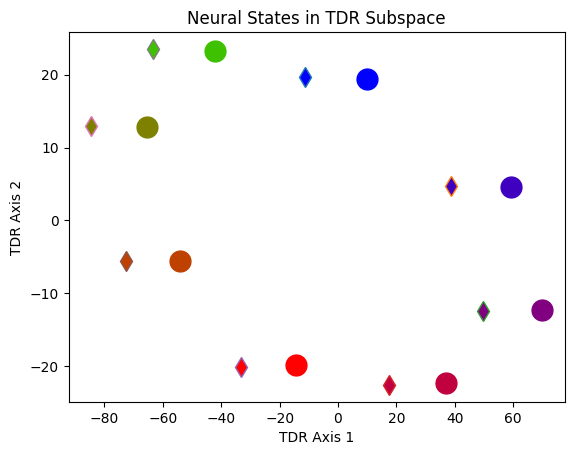

In [110]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming projectedStates is your (8,2) matrix
n_cond = int(projectedStates.shape[0] / 2)


angle_set = np.deg2rad(np.arange(0, 360, 45))  # 8 directions
color_list = [plt.cm.brg(cond / (2 * np.pi)) for cond in angle_set]

# Create a scatter plot
plt.figure()
for i in range(n_cond):
    plt.plot(projectedStates[i, 0], projectedStates[i, 1], '.', markersize=30, color=color_list[i])
    plt.plot(projectedStates[i + n_cond, 0], projectedStates[i + n_cond, 1], 'd', markersize=10, markerfacecolor=color_list[i])

plt.xlabel('TDR Axis 1')
plt.ylabel('TDR Axis 2')
plt.title('Neural States in TDR Subspace')

plt.show()
